In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# load dataset
data = read_csv('energydata_complete.csv', header=0, index_col=0)
print(data.head())
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

                     Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

                        T3       RH_3         T4       RH_4    ...      \
date                                                           ...       
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566667    ...       
2016-01-11 17:10:00  19.79  44.790000  19.000000  45.992500    ...       
2016-01-11 17:20:00  19.79  44.933333  18.926667  45.890000    ...       
2016-01-11 17:30:00  19.79  45.000000  18.890000  45.723333    ...       
2016-01-1

In [5]:
from statsmodels.tsa.vector_ar.var_model import VAR
# Implementing VAR method
def VectorAutoRegression(data):
    #creating the train and validation set
    train = data[:int(0.8*(len(data)))]
    test = data[int(0.8*(len(data))):]
    print(len(test[:,0]))
    #fit the VAR model
    model = VAR(endog=train)
    model_fit = model.fit()
    prediction = model_fit.forecast(model_fit.y, steps=len(test))
    mae = mean_absolute_error(prediction[:,0], test[:,0])
    mse = mean_squared_error(prediction[:,0], test[:,0])
    return prediction[:,0], mse, mae, test[:,0]
    #fit the VARMA model
    """model = VARMAX(train, order=(1, 1))
    model_fit = model.fit()
    prediction = model_fit.forecast()
    MAE['VARMA'] = mean_absolute_error(prediction[0], test[0])
    MSE['VARMA'] = mean_squared_error(prediction[0], test[0])
    """

In [6]:
# convert time-series data to supervised data
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for j in range(0,n_vars):
        for i in range(n_in[j], 0, -1):
            cols.append(df[j].shift(i))
            names += [('var%d(t-%d)' % (j+1, i))]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
def split_data(data, n_lag, n_features,flag):
    n_obs = sum(n_lag)
    reframed = series_to_supervised(data, n_lag, 1)
    if flag==1 :
        print(reframed.head())
    # split into train and test sets
    values = reframed.values
    n_train = int(0.8*(len(data)))
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    #print(train_X.shape, len(train_X), train_y.shape)
    return train_X, train_y, test_X, test_y

In [8]:
# Implementing Linear Regression method
def LinearReg(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = LinearRegression()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [9]:
# Implementing SVM method
def SVM_Gausian(data, n_lag, n_features,flag):
    # Fit SVM 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = SVR(kernel='rbf')
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [10]:
# Implementing SVM method
def SVM_Linear(data, n_lag, n_features,flag):
    # Fit SVM 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = SVR(kernel='linear')
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [11]:
# Implementing Lasso Regression method
def LassoRegression(data, n_lag, n_features,flag):
    # Fit Lasso 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = Lasso()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [12]:
# Implementing Lasso Regression method
def RidgeRegression(data, n_lag, n_features,flag):
    # Fit Lasso 
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    model = Ridge()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mae = mean_absolute_error(prediction, test_y)
    mse = mean_squared_error(prediction, test_y)
    return prediction, mse, mae, test_y

In [13]:
def LinearRegPSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=LinearReg(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=LinearReg(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [14]:
def SVM_Gausian_PSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=SVM_Gausian(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [15]:
def SVM_Linear_PSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=SVM_Linear(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [16]:
def LassoRegPSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=LassoRegression(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [17]:
def RidgeRegPSO(data,w1,c1,c2,maxI,npop,wdamp,n_features,m) :
    print()
    print("USING PSO")
    Globalcost=2**10000
    Globalpos=[]
    for j in range(0, n_features):
        Globalpos.append(int(0))

    class Particle:
        def __init__(self):
            self.position=np.random.randint(1,m,(npop,n_features))
            self.velocity=np.zeros((npop,n_features))
            self.cost=[]      
            self.bestcost=[]        
            self.bestposition=np.random.randint(1,m,(npop,n_features))

    s1=Particle()
    print(s1.position.dtype)
    for i in range(0,npop):
        
        pred,mse,mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
        s1.cost.append(mse)
        s1.bestcost.append(mse)
        if mse<Globalcost :
            Globalcost=mse
            Globalpos=s1.position[i,:]
    
    # Main loop of PSO
    
    for it in range(0,maxI) :
        for i in range(0,npop) :
            for j in range(0,n_features):
                r1=random.random()
                r2=random.random()
                s1.velocity[i][j] = w1*s1.velocity[i][j] + c1*r1*(s1.bestposition[i][j] - s1.position[i][j]) + c2*r2*(Globalpos[j] - s1.position[i][j])
                s1.position[i][j] = int(s1.position[i][j] + s1.velocity[i][j])
                s1.position[i][j] = int(max(s1.position[i][j],1))
                s1.position[i][j] = int(min(s1.position[i][j],m))

            pred,s1.cost[i],mae,test=RidgeRegression(data,s1.position[i,:],n_features,0)
            if s1.cost[i] < s1.bestcost[i] :
                s1.bestcost[i] = s1.cost[i]
                s1.bestposition[i,:] = s1.position[i,:]
                if s1.bestcost[i] < Globalcost :
                    Globalcost = s1.bestcost[i]
                    Globalpos = s1.bestposition[i,:]
        x = Globalpos
        y = Globalcost
        print("Iteration: " + str(it+1) + " ; " + "Bestposition = " + str(x) + "  Bestcost = " + str(y) )
        w1 = w1*wdamp
    return Globalcost,Globalpos


In [18]:
# plot 2 lines
def plot(y1,y2,title,file_name):
    x = []
    for i in range(0,len(y1)):
        x.append(i+1)
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.plot(x, y1, label = "Actual")   
    plt.plot(x, y2, label = "Predicted") 
    # naming the x axis 
    plt.xlabel('x - axis') 
    # naming the y axis 
    plt.ylabel('Appliance energy') 
    # giving a title to my graph 
    plt.title(title) 
    # show a legend on the plot 
    plt.legend() 
    # function to show the plot 
    
    plt.savefig(file_name,dpi=1200)
    plt.show()

In [19]:
methods = ["VAR","LinearRegression","SVM_Gausian","SVM_Linear","LassoRegression","RidgeRegression","LinearRegPSO","SVM_Gausian_PSO","SVM_Linear_PSO","LassoRegPSO","RidgeRegPSO"]
MSE = {}
MAE = {}
for i in range(0,len(methods)):
    MSE[methods[i]]=0.0
    MAE[methods[i]]=0.0
print(MSE)
print(MAE)

{'VAR': 0.0, 'LinearRegression': 0.0, 'SVM_Gausian': 0.0, 'SVM_Linear': 0.0, 'LassoRegression': 0.0, 'RidgeRegression': 0.0, 'LinearRegPSO': 0.0, 'SVM_Gausian_PSO': 0.0, 'SVM_Linear_PSO': 0.0, 'LassoRegPSO': 0.0, 'RidgeRegPSO': 0.0}
{'VAR': 0.0, 'LinearRegression': 0.0, 'SVM_Gausian': 0.0, 'SVM_Linear': 0.0, 'LassoRegression': 0.0, 'RidgeRegression': 0.0, 'LinearRegPSO': 0.0, 'SVM_Gausian_PSO': 0.0, 'SVM_Linear_PSO': 0.0, 'LassoRegPSO': 0.0, 'RidgeRegPSO': 0.0}


3947


C:\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


MSE for VAR method: 0.007211959691707641
MAE for VAR method: 0.0485715465229016


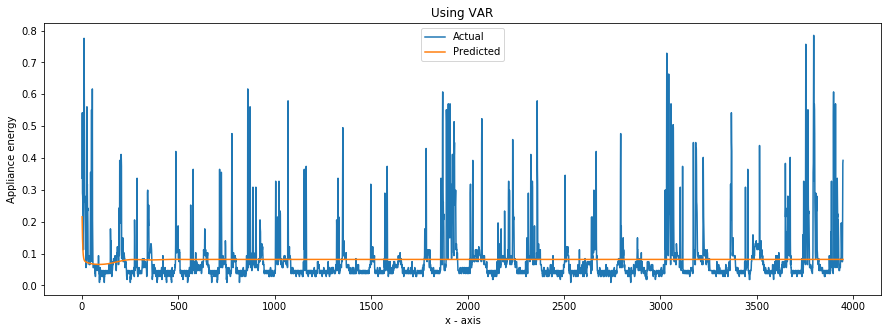

In [20]:
# Call VAR model
prediction, MSE['VAR'], MAE['VAR'], test = VectorAutoRegression(scaled)
print("MSE for VAR method: " + str(MSE['VAR']))
print("MAE for VAR method: " + str(MAE['VAR']))
plot(test, prediction, 'Using VAR','VAR.png')

   var1(t-2)  var1(t-1)  var2(t-3)  var2(t-2)  var2(t-1)  var3(t-2)  \
3   0.046729   0.037383   0.428571   0.428571   0.428571   0.327349   
4   0.037383   0.037383   0.428571   0.428571   0.571429   0.327349   
5   0.037383   0.046729   0.428571   0.571429   0.571429   0.327349   
6   0.046729   0.037383   0.571429   0.571429   0.571429   0.327349   
7   0.037383   0.046729   0.571429   0.571429   0.714286   0.327349   

   var3(t-1)  var4(t-3)  var4(t-2)  var4(t-1)    ...     var19(t)  var20(t)  \
3   0.327349   0.566187   0.541326   0.530502    ...     0.219563  0.671909   
4   0.327349   0.541326   0.530502   0.524080    ...     0.219563  0.671909   
5   0.327349   0.530502   0.524080   0.531419    ...     0.219563  0.667356   
6   0.327349   0.524080   0.531419   0.522980    ...     0.219563  0.667356   
7   0.327349   0.531419   0.522980   0.515824    ...     0.219563  0.667356   

   var21(t)  var22(t)  var23(t)  var24(t)  var25(t)  var26(t)  var27(t)  \
3  0.361736  0.104652  

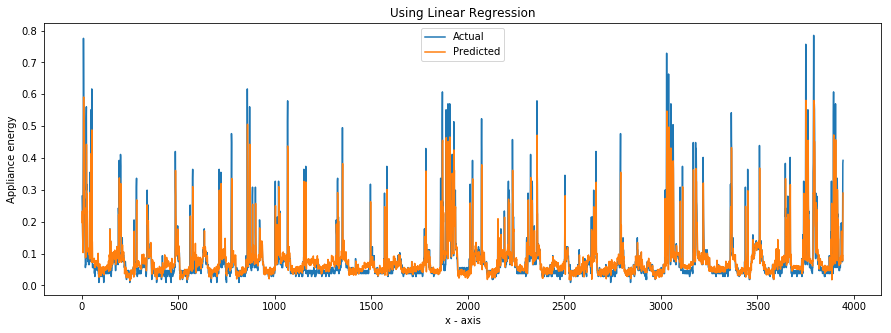

In [21]:
# Call Linear Regression model
n_lag = []
n_features = 28
for i in range(0,n_features):
    if i%2==0:
        n_lag.append(2)
    else:
        n_lag.append(3)
prediction, MSE['LinearRegression'], MAE['LinearRegression'], test = LinearReg(scaled, n_lag, n_features,1)
print("MSE for Linear Regression method: " + str(MSE['LinearRegression']))
print("MAE for Linear Regression method: " + str(MAE['LinearRegression']))
plot(test, prediction, 'Using Linear Regression','Linear Regression.png')

MSE for SVM_Gausian method: 0.00757482115522261
MAE for SVM_Gausian method: 0.07872774685449496


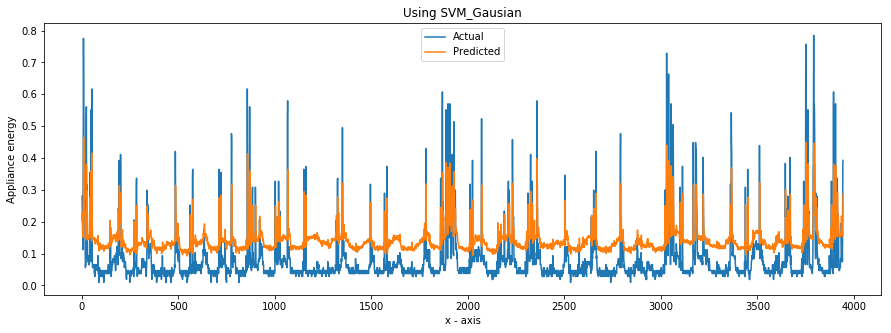

In [22]:
# Call SVM Gausian model
prediction, MSE['SVM_Gausian'], MAE['SVM_Gausian'], test = SVM_Gausian(scaled, n_lag, n_features,0)
print("MSE for SVM_Gausian method: " + str(MSE['SVM_Gausian']))
print("MAE for SVM_Gausian method: " + str(MAE['SVM_Gausian']))
plot(test, prediction, 'Using SVM_Gausian','SVM_Gausian.png')

MSE for SVM_Linear method: 0.006942378427962659
MAE for SVM_Linear method: 0.07382870633062541


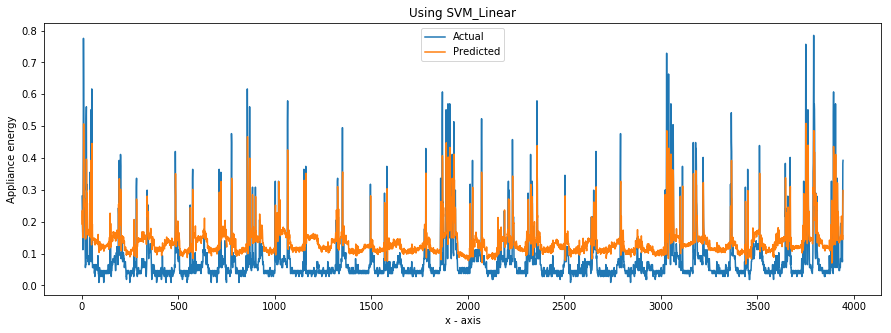

In [23]:
# Call SVM Linear model
prediction, MSE['SVM_Linear'], MAE['SVM_Linear'], test = SVM_Linear(scaled, n_lag, n_features,0)
print("MSE for SVM_Linear method: " + str(MSE['SVM_Linear']))
print("MAE for SVM_Linear method: " + str(MAE['SVM_Linear']))
plot(test, prediction, 'Using SVM_Linear','SVM_Linear.png')

MSE for Lasso Regression method: 0.007166294
MAE for Lasso Regression method: 0.049073108


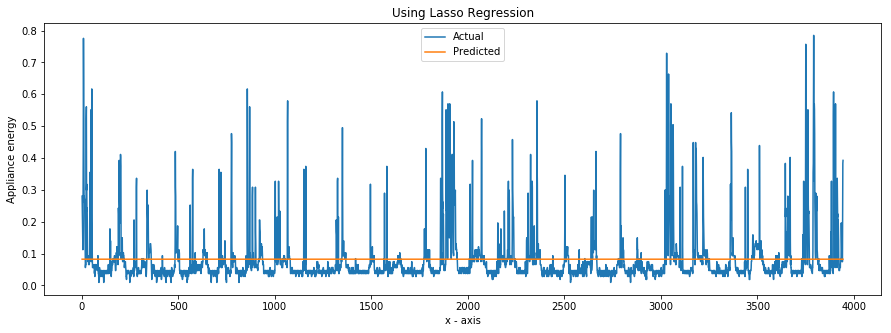

In [24]:
# Call Lasso Regression model
prediction, MSE['LassoRegression'], MAE['LassoRegression'], test = LassoRegression(scaled, n_lag, n_features,0)
print("MSE for Lasso Regression method: " + str(MSE['LassoRegression']))
print("MAE for Lasso Regression method: " + str(MAE['LassoRegression']))
plot(test, prediction, 'Using Lasso Regression','Lasso Regression.png')

MSE for Ridge Regression method: 0.0032721302
MAE for Ridge Regression method: 0.027116172


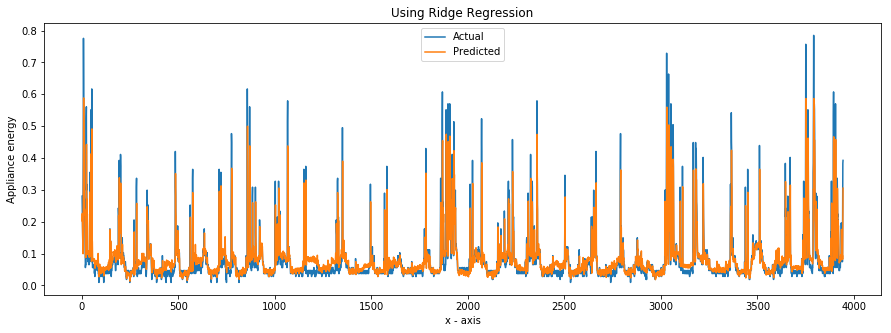

In [25]:
# Call Ridge Regression model
prediction, MSE['RidgeRegression'], MAE['RidgeRegression'], test = RidgeRegression(scaled, n_lag, n_features,0)
print("MSE for Ridge Regression method: " + str(MSE['RidgeRegression']))
print("MAE for Ridge Regression method: " + str(MAE['RidgeRegression']))
plot(test, prediction, 'Using Ridge Regression','Ridge Regression.png')

In [26]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Linear regression PSO call
mse, n_lag = LinearRegPSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)


USING PSO
int32
Iteration: 1 ; Bestposition = [ 5  7 20  8 20 15 17  7  4 10 12 11 11 11  3 10 16 10 14  1  1 17 12  2
 10  6  2  1]  Bestcost = 0.0031504252
Iteration: 2 ; Bestposition = [ 1 17 20 12 20 20 16  1 20 15  8  9 12 20  2 11 20  4 20  1  2  7 15  3
 16 14  1  1]  Bestcost = 0.0031504252
Iteration: 3 ; Bestposition = [ 1 20 20 12 20 20 16  1 20 17  5  7 13 20  3 13 20  4 18  1  3  1 18  5
 20 20  2  1]  Bestcost = 0.0031504252
Iteration: 4 ; Bestposition = [ 1 17 20 10 20 14 16  1 20 16 10 10 13 20  6 15 20 10 16  1  4  9 19 18
 20 20  3  1]  Bestcost = 0.0031504252
Iteration: 5 ; Bestposition = [ 1 14 20  5 20  9 18  1 20  8 15 15 11 17  9 14 20 15  8  1  2 18 13 20
 19 20  5  2]  Bestcost = 0.0031504252
Iteration: 6 ; Bestposition = [ 1 11 20  1 20 11 19  1 20  8 16 13 10  8 11 13 20 20  6  1  1 20 10 20
 12 19  7 11]  Bestcost = 0.0031504252
Iteration: 7 ; Bestposition = [ 2 10 20  6 20 18 18  1 17 12  8  7 11  1 10 12 20  4 10  1  1 10  9 14
 11 15  6 15]  Bestcost = 0.

MSE for Linear Regression with PSO method: 0.0031267845
MAE for Linear Regression with PSO method: 0.027921109


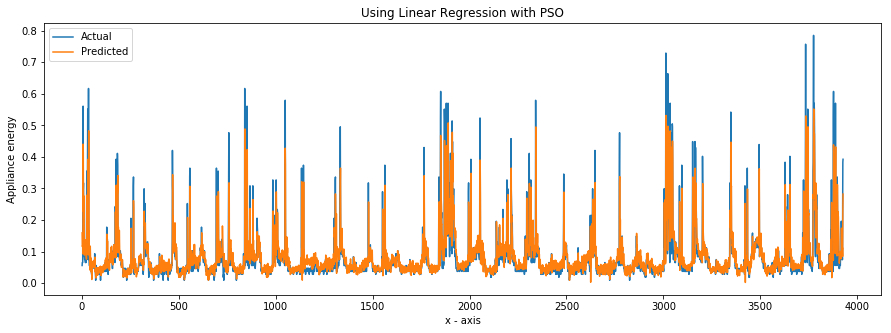

In [27]:
# Use Result from Linear Regression with PSO method
prediction, MSE['LinearRegPSO'], MAE['LinearRegPSO'], test = LinearReg(scaled, n_lag, n_features,0)
print("MSE for Linear Regression with PSO method: " + str(MSE['LinearRegPSO']))
print("MAE for Linear Regression with PSO method: " + str(MAE['LinearRegPSO']))
plot(test, prediction, 'Using Linear Regression with PSO','Linear Regression with PSO.png')

In [28]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Call SVM-Gausian-PSO method
mse, n_lag = SVM_Gausian_PSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)


USING PSO
int32
Iteration: 1 ; Bestposition = [19 13 20  1  3 11  6 13 20  5  1 20 20 19 14  7 20 20 17  9  1  5  3 18
  3 20  1 12]  Bestcost = 0.007599797080913633
Iteration: 2 ; Bestposition = [20  1 20  1  1 17  1 20 20  6  1 20 20  1 20 20  4  9  1 10  1 20 17 20
  2 20  1 20]  Bestcost = 0.0073947500196203724
Iteration: 3 ; Bestposition = [20  1 20 20  1 20  1 16 20  1  1 20 20  2 20 20  2 13  1 10  1 20 16 12
  1 19  1 20]  Bestcost = 0.007391733755428515
Iteration: 4 ; Bestposition = [20  1 20 20  1 20  1 16 20  1  1 20 20  2 20 20  2 13  1 10  1 20 16 12
  1 19  1 20]  Bestcost = 0.007391733755428515
Iteration: 5 ; Bestposition = [20  1 20 20  1 20  1 20 20  3  1 20 20  1 20 20  6 13  1  9  1 20 13  6
  1 20  1 20]  Bestcost = 0.007390198069649073
Iteration: 6 ; Bestposition = [20  1 20 20  1 20  1 20 20  3  1 20 20  1 20 20  6 13  1  9  1 20 13  6
  1 20  1 20]  Bestcost = 0.007390198069649073
Iteration: 7 ; Bestposition = [20  1 20 20  1 20  1 20 20  4  1 20 20  1 20 20  6 

MSE for SVM_Gausian with PSO method: 0.007347174478843418
MAE for SVM_Gausian with PSO method: 0.07688979289376816


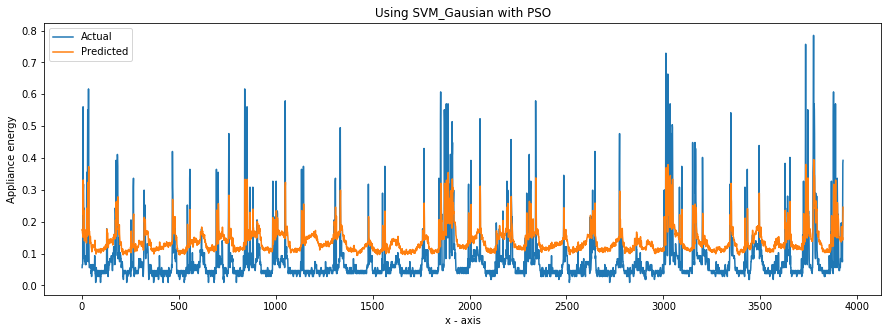

In [29]:
# Use Result from SVM-Gausian with PSO method
prediction, MSE['SVM_Gausian_PSO'], MAE['SVM_Gausian_PSO'], test = SVM_Gausian(scaled, n_lag, n_features,0)
print("MSE for SVM_Gausian with PSO method: " + str(MSE['SVM_Gausian_PSO']))
print("MAE for SVM_Gausian with PSO method: " + str(MAE['SVM_Gausian_PSO']))
plot(test, prediction, 'Using SVM_Gausian with PSO','SVM_Gausian_PSO.png')


USING PSO
int32
Iteration: 1 ; Bestposition = [ 6 10  1 13  6  4 13 15  1  1  9  6 10  1  1 17 20  2 12  8 12  1 18 15
  3  3 14  3]  Bestcost = 0.006360772058345821
Iteration: 2 ; Bestposition = [ 1 13  1 18  3  1 20 11  1  1  1  5 10  1  1 13 20  1 16  7  8  1 20 15
  2  1  8  8]  Bestcost = 0.006360772058345821
Iteration: 3 ; Bestposition = [ 1 12  1 17  1 10 20 17  1  1  1  3  8  1  2  7 20  1 20 20 11  1 20  1
  6  1  1  1]  Bestcost = 0.006189538279760559
Iteration: 4 ; Bestposition = [ 1 12  1 17  1 10 20 17  1  1  1  3  8  1  2  7 20  1 20 20 11  1 20  1
  6  1  1  1]  Bestcost = 0.006189538279760559
Iteration: 5 ; Bestposition = [ 1 12  1 17  1 10 20 17  1  1  1  3  8  1  2  7 20  1 20 20 11  1 20  1
  6  1  1  1]  Bestcost = 0.006189538279760559
Iteration: 6 ; Bestposition = [ 1 12  1 17  1 10 20 17  1  1  1  3  8  1  2  7 20  1 20 20 11  1 20  1
  6  1  1  1]  Bestcost = 0.006189538279760559
Iteration: 7 ; Bestposition = [ 1 12  1 17  1 10 20 17  1  1  1  3  8  1  2  7 20  

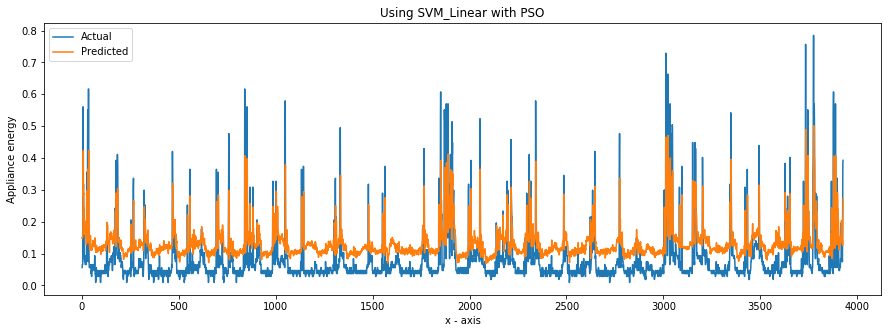

In [30]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Call SVM-Linear-PSO method
mse, n_lag = SVM_Linear_PSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)
# Use Result from SVM-Linear with PSO method
prediction, MSE['SVM_Linear_PSO'], MAE['SVM_Linear_PSO'], test = SVM_Linear(scaled, n_lag, n_features,0)
print("MSE for SVM_Linear with PSO method: " + str(MSE['SVM_Linear_PSO']))
print("MAE for SVM_Linear with PSO method: " + str(MAE['SVM_Linear_PSO']))
plot(test, prediction, 'Using SVM_Linear with PSO','SVM_Linear_PSO.png')


USING PSO
int32
Iteration: 1 ; Bestposition = [ 1  1  5  1 14  9 13 13 20 16 11 12  1 14 18 20 11  1 12  5  7  9 11 16
  9 11 16  9]  Bestcost = 0.006866571
Iteration: 2 ; Bestposition = [ 1  1  4  1 10 10 20 13 20 20 16 12  1 20 20 20 13  1  6  1  1  4  9 20
  6  6 16 14]  Bestcost = 0.006866571
Iteration: 3 ; Bestposition = [ 1  1 11  1  9 10 19 13 20 20 19 12  1 20 20 20 13  1  2  1  1  1  7 15
  2  9 20 18]  Bestcost = 0.006866571
Iteration: 4 ; Bestposition = [ 1  1 18  1  8  9 16 15 20 20 15 12  1 20 17 20 12  1  3  1  1  1 12  9
  4 12 20 17]  Bestcost = 0.006866571
Iteration: 5 ; Bestposition = [ 1  1 20  1 14  8 13 16 20 20 11 12  1 13  8 20 10  1  5  1  1  6 17 13
  7 12 18 12]  Bestcost = 0.006866571
Iteration: 6 ; Bestposition = [ 1  1 16  2 19  7 12 14 20 18  7 12  1  7  7 20  9  1 10  1  1 11 20 17
  6  8 16  7]  Bestcost = 0.006866571
Iteration: 7 ; Bestposition = [ 1  1 11  3 11 10 12 12 20 16  4 12  1  7 10 20  8  1 14  1  1 12 20 20
  3  4 16  8]  Bestcost = 0.006866

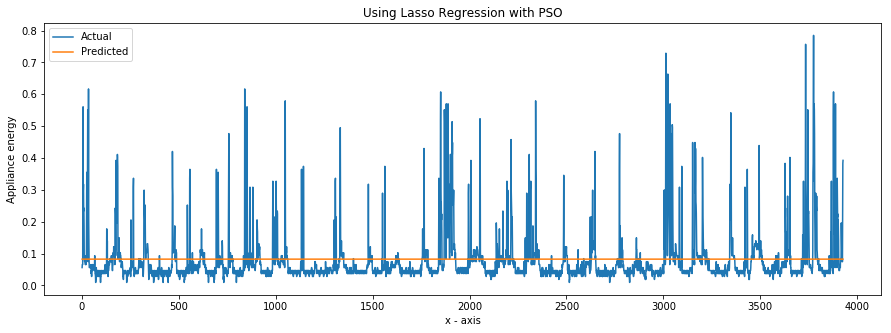

In [31]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Lasso regression PSO call
mse, n_lag = LassoRegPSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)
# Use Result from Lasso Regression with PSO method
prediction, MSE['LassoRegPSO'], MAE['LassoRegPSO'], test = LassoRegression(scaled, n_lag, n_features,0)
print("MSE for Lasso Regression with PSO method: " + str(MSE['LassoRegPSO']))
print("MAE for Lasso Regression with PSO method: " + str(MAE['LassoRegPSO']))
plot(test, prediction, 'Using Lasso Regression with PSO','Lasso Regression with PSO.png')


USING PSO
int32
Iteration: 1 ; Bestposition = [ 8 17  1 16  3  9 15  3 15  7 18 14 10 19  9  1 15 20 16  6  7  4 12 20
  4  4 17 18]  Bestcost = 0.0031060488
Iteration: 2 ; Bestposition = [ 8 17  1 19  2  1 20  1  8  1 20 10 15 20  4  1 10 20 10  7  1  3 20 20
  4 20 20 20]  Bestcost = 0.0031060488
Iteration: 3 ; Bestposition = [ 6 20  1 19  1  9 20  1  6  1 13  3  1 20  1  4 17 20 20 20  1  1 20 20
  1  1 20 20]  Bestcost = 0.0031052781
Iteration: 4 ; Bestposition = [11 20  1 20  1  1 20  1  1  1  7  1  1 20  1  1 14 20 20 20  1  1 20 20
  1  1 20 20]  Bestcost = 0.0030802325
Iteration: 5 ; Bestposition = [11 20  1 20  1  1 20  1  1  1  7  1  1 20  1  1 14 20 20 20  1  1 20 20
  1  1 20 20]  Bestcost = 0.0030802325
Iteration: 6 ; Bestposition = [11 20  1 20  1  1 20  1  1  1  7  1  1 20  1  1 14 20 20 20  1  1 20 20
  1  1 20 20]  Bestcost = 0.0030802325
Iteration: 7 ; Bestposition = [11 20  1 20  1  1 20  1  1  1  7  1  1 20  1  1 14 20 20 20  1  1 20 20
  1  1 20 20]  Bestcost = 0.

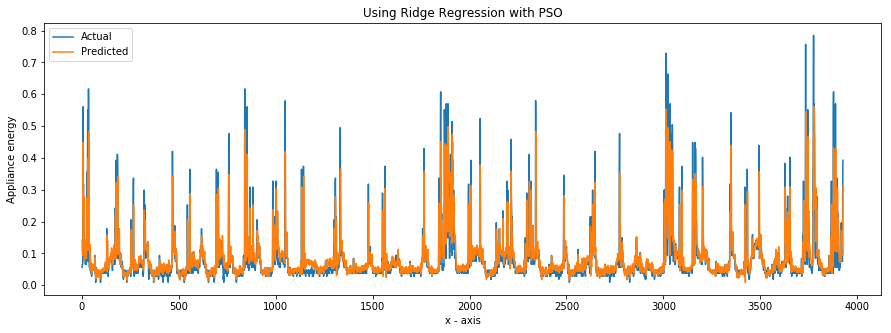

In [32]:
# PSO Parameters
m=20
maxI=10
npop=5
w1=1
wdamp=0.99
c1=2
c2=2
# Lasso regression PSO call
mse, n_lag = RidgeRegPSO(scaled,w1,c1,c2,maxI,npop,wdamp,n_features,m)
# Use Result from Lasso Regression with PSO method
prediction, MSE['RidgeRegPSO'], MAE['RidgeRegPSO'], test = RidgeRegression(scaled, n_lag, n_features,0)
print("MSE for Ridge Regression with PSO method: " + str(MSE['RidgeRegPSO']))
print("MAE for Ridge Regression with PSO method: " + str(MAE['RidgeRegPSO']))
plot(test, prediction, 'Using Ridge Regression with PSO','Ridge Regression with PSO.png')

In [35]:
print(MSE)
print(MAE)

{'VAR': 0.007211959691707641, 'LinearRegression': 0.0032754058, 'SVM_Gausian': 0.00757482115522261, 'SVM_Linear': 0.006942378427962659, 'LassoRegression': 0.007166294, 'RidgeRegression': 0.0032721302, 'LinearRegPSO': 0.0031267845, 'SVM_Gausian_PSO': 0.007347174478843418, 'SVM_Linear_PSO': 0.006189538279760559, 'LassoRegPSO': 0.006868287, 'RidgeRegPSO': 0.003080215}
{'VAR': 0.0485715465229016, 'LinearRegression': 0.027351558, 'SVM_Gausian': 0.07872774685449496, 'SVM_Linear': 0.07382870633062541, 'LassoRegression': 0.049073108, 'RidgeRegression': 0.027116172, 'LinearRegPSO': 0.027921109, 'SVM_Gausian_PSO': 0.07688979289376816, 'SVM_Linear_PSO': 0.0683913163627069, 'LassoRegPSO': 0.048459273, 'RidgeRegPSO': 0.026766665}


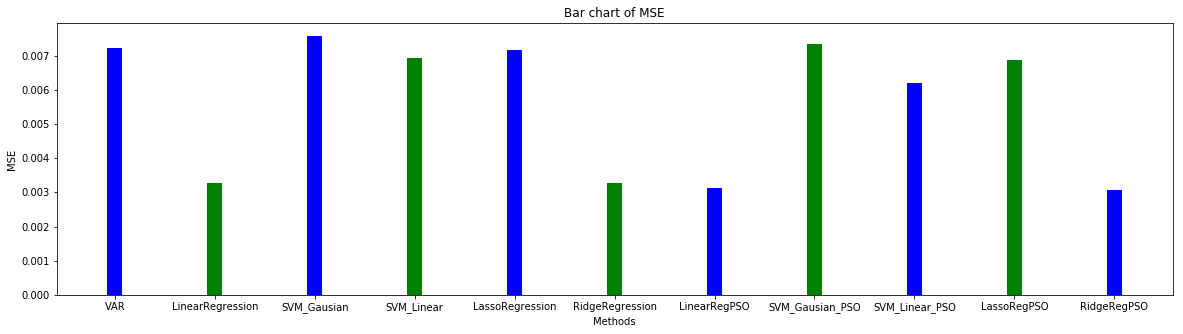

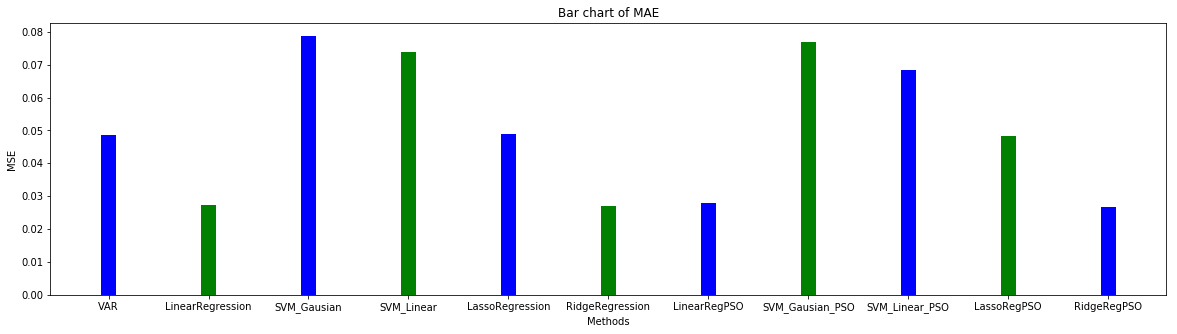

In [34]:
performance = []
for i in range(0,11):
    performance.append(MSE[methods[i]])
    

# x-coordinates of left sides of bars  
left = [1, 3, 5, 7 , 9, 11, 13, 15, 17, 19, 21] 
# plotting a bar chart 
plt.rcParams['figure.figsize'] = [20, 5]
plt.bar(left, performance, tick_label = methods, width = 0.3, color = ['blue', 'green']) 
  
# naming the x-axis 
plt.xlabel('Methods') 
# naming the y-axis 
plt.ylabel('MSE') 
# plot title 
plt.title('Bar chart of MSE') 
# function to show the plot 
plt.savefig('MSE.png',dpi=1200)
plt.show() 





for i in range(0,11):
    performance[i]=MAE[methods[i]]
# plotting a bar chart 
plt.rcParams['figure.figsize'] = [20, 5]
plt.bar(left, performance, tick_label = methods, width = 0.3, color = ['blue', 'green']) 
# naming the x-axis 
plt.xlabel('Methods') 
# naming the y-axis 
plt.ylabel('MSE') 
# plot title 
plt.title('Bar chart of MAE') 
# function to show the plot
plt.savefig('MAE.png',dpi=1200)
plt.show() 

In [ ]:
for i in range(0,11):
    print(str(i+1) + ": " + str(methods[i]))